In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
train_files_path_0 = '/content/gdrive/MyDrive/GL_AIML/Capstone_Project/Data_for_DenseNet/train_dataset/class_0/'
tf= os.listdir(train_files_path_0)
print(len(tf))

20672


In [4]:
train_files_path_1 = '/content/gdrive/MyDrive/GL_AIML/Capstone_Project/Data_for_DenseNet/train_dataset/class_1/'
tf= os.listdir(train_files_path_1)
print(len(tf))

6012


In [5]:
from PIL import Image
import numpy as np
from tensorflow.keras.applications.densenet import preprocess_input
tfp1 = os.listdir(train_files_path_0)
X_train = []
count=0
for i in tfp1:
  count=count+1
  img =Image.open(train_files_path_0+i)
  X_train.append(preprocess_input(np.array(img,dtype=np.float32)))
  if(count==10000):
    break

In [6]:
tfp2 = os.listdir(train_files_path_1)
for i in tfp2:
  img =Image.open(train_files_path_1+i)
  X_train.append(preprocess_input(np.array(img,dtype=np.float32)))

In [7]:
len(X_train)

16012

In [8]:
X_train = np.array(X_train)

In [9]:
X_train.shape

(16012, 224, 224, 3)

In [10]:
y_train = np.zeros(16012)
for i in range(10000,16012):
  y_train[i] = 1.0

In [11]:
(unique, counts) = np.unique(y_train, return_counts=True)

In [12]:
unique

array([0., 1.])

In [13]:
counts

array([10000,  6012])

In [14]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [15]:
X_train.shape

(16012, 224, 224, 3)

In [16]:
y_train.shape

(16012,)

In [17]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size =0.10)

In [18]:
X_train.shape

(14410, 224, 224, 3)

In [19]:
y_train.shape

(14410,)

In [20]:
X_val.shape

(1602, 224, 224, 3)

In [21]:
y_val.shape

(1602,)

In [22]:
(unique_train, counts_train) = np.unique(y_train, return_counts=True)

In [23]:
(unique_val, counts_val) = np.unique(y_val, return_counts=True)

In [24]:
print('No of patients with pnuemonia in train set = '+str(counts_train[1]))
print('No of patients without pnuemonia in train set = '+str(counts_train[0]))

No of patients with pnuemonia in train set = 5391
No of patients without pnuemonia in train set = 9019


In [25]:
print('% patients with pnuemonia in train set = '+str(100.0*counts_train[1]/(counts_train[1]+counts_train[0])))

% patients with pnuemonia in train set = 37.41151977793199


In [26]:
print('No of patients with pnuemonia in validation set = '+str(counts_val[1]))
print('No of patients without pnuemonia in validation set = '+str(counts_val[0]))

No of patients with pnuemonia in validation set = 621
No of patients without pnuemonia in validation set = 981


In [27]:
print('% patients with pnuemonia in val set = '+str(100.0*counts_val[1]/(counts_val[1]+counts_val[0])))

% patients with pnuemonia in val set = 38.764044943820224


In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [29]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(224, 224, 3)) 
for layer in model_d.layers[:-10]:
    layer.trainable = False
for layer in model_d.layers[-10:]:
    layer.trainable = True
x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(1,activation='sigmoid')(x) #FC-layer

29089792/29084464 [==============================] - 0s 0us/step


In [30]:

model=Model(inputs=model_d.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [31]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("/content/drive/MyDrive/GL_AIML/Capstone_Project/densenet_model.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=5)

In [33]:
history = model.fit(X_train, y_train,validation_data=(X_val,y_val),epochs=20, batch_size=32, verbose=1)

Epoch 1/20
451/451 [==============================] - 52s 70ms/step - loss: 0.6082 - accuracy: 0.7191 - val_loss: 0.4848 - val_accuracy: 0.7753
Epoch 2/20
451/451 [==============================] - 30s 66ms/step - loss: 0.4756 - accuracy: 0.7710 - val_loss: 0.4543 - val_accuracy: 0.7871
Epoch 3/20
451/451 [==============================] - 30s 66ms/step - loss: 0.4533 - accuracy: 0.7855 - val_loss: 0.4651 - val_accuracy: 0.7859
Epoch 4/20
451/451 [==============================] - 30s 66ms/step - loss: 0.4344 - accuracy: 0.7910 - val_loss: 0.4553 - val_accuracy: 0.8009
Epoch 5/20
451/451 [==============================] - 30s 66ms/step - loss: 0.4190 - accuracy: 0.8033 - val_loss: 0.4697 - val_accuracy: 0.7734
Epoch 6/20
451/451 [==============================] - 30s 66ms/step - loss: 0.3967 - accuracy: 0.8186 - val_loss: 0.4715 - val_accuracy: 0.7765
Epoch 7/20
451/451 [==============================] - 30s 66ms/step - loss: 0.3721 - accuracy: 0.8342 - val_loss: 0.5051 - val_accuracy:

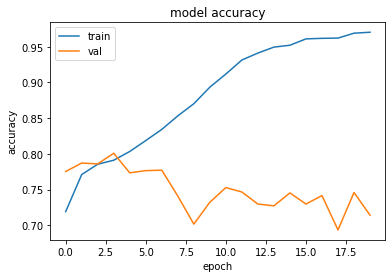

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

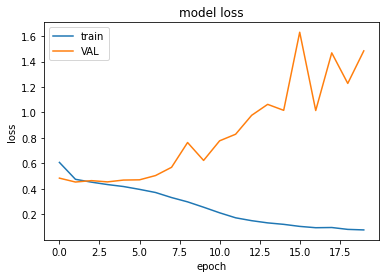

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'VAL'], loc='upper left')
plt.show()